In [50]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (20, 8)})

In [51]:
from models_gaussian_2d import *
from eval_utils import *
import time

In [52]:
from sklearn.decomposition import PCA
from celluloid import Camera
import matplotlib.cm as cm
from IPython.display import display, Markdown, Latex, HTML

In [83]:
import os
# os.chdir('./wodociagi')

In [84]:
import pandas as pd
import numpy as np

In [85]:
plt.rcParams.update({'figure.figsize': (20, 8)})

# Prepare Data

In [86]:
df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())

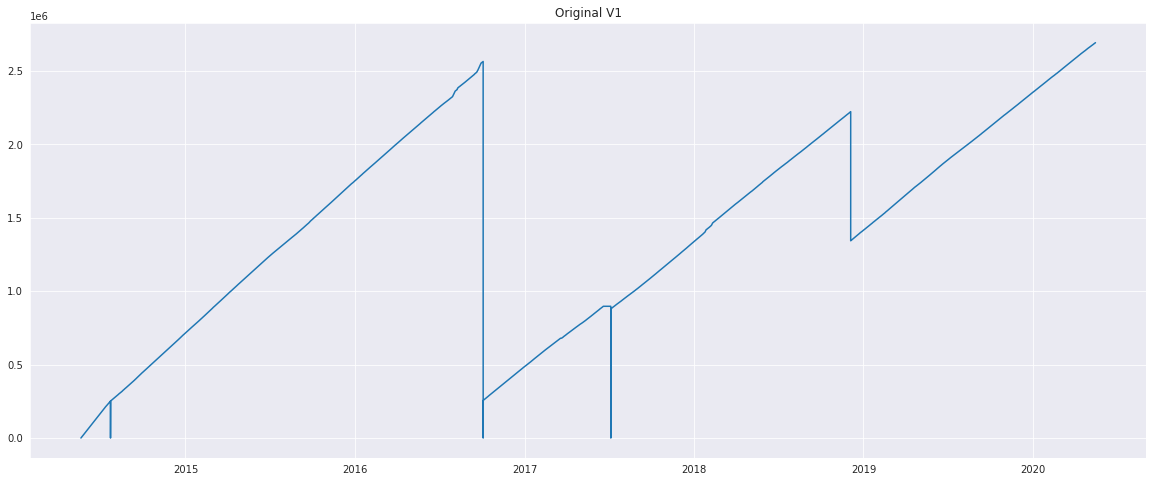

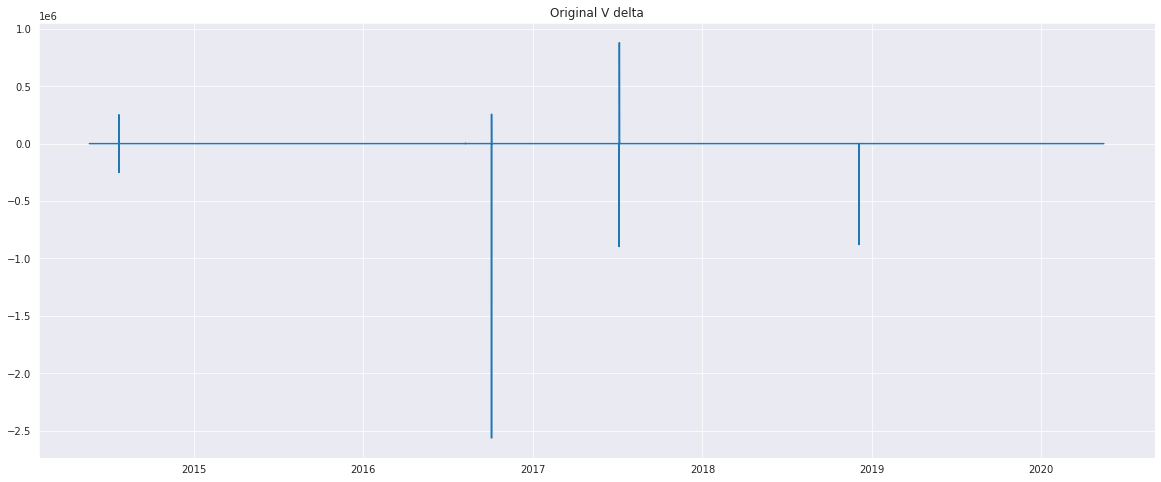

In [87]:
plt.plot(df_main["mtime"], df_main["V1"])
plt.title("Original V1")
plt.show()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("Original V delta")
plt.show()

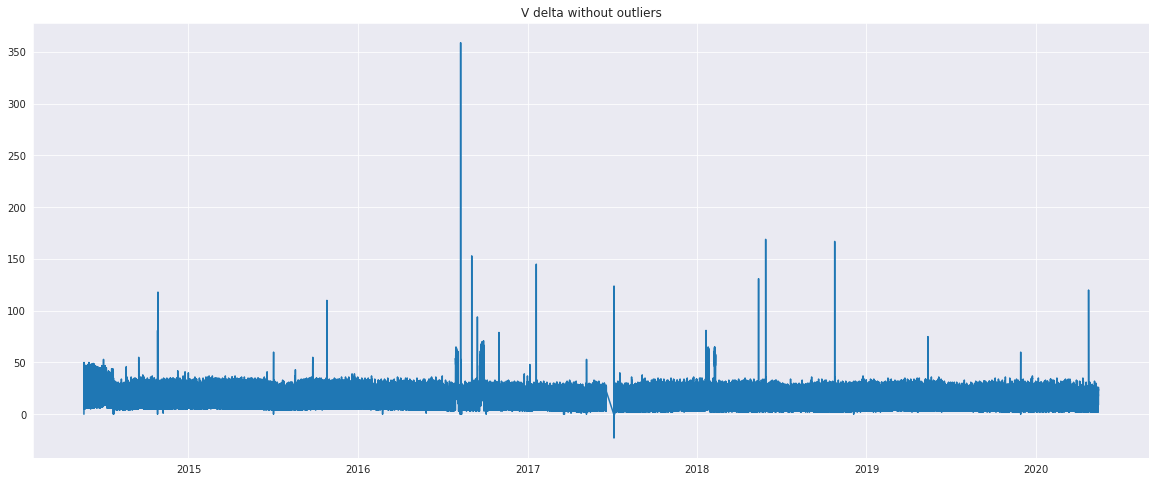

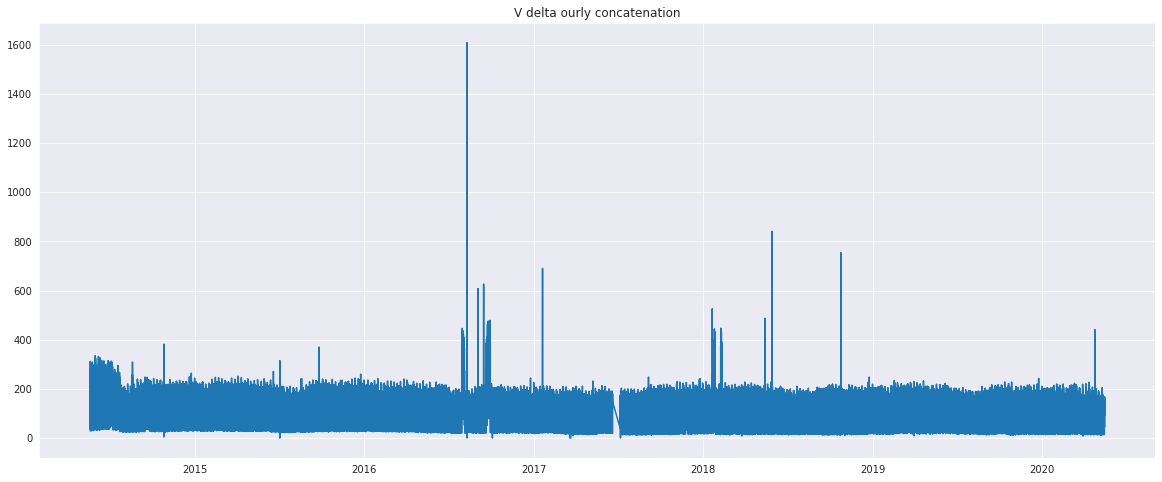

In [88]:
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta without outliers")
plt.show()

df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()

plt.plot(df_main["mtime"], df_main["V_delta"])
plt.title("V delta ourly concatenation")
plt.show()

In [2]:
plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], df_main.loc[(df_main.mtime.dt.year == 2019), "V_delta"])


seasonal_changes = df_main.V_delta.rolling(24 * 42 * 6, center=True, min_periods=2).mean().rolling(24 * 7 * 6, center=True, min_periods=2).mean()[(df_main.mtime.dt.year == 2019)]

plt.plot(df_main.loc[(df_main.mtime.dt.year == 2019), "mtime"], seasonal_changes , color = "red")
plt.title("V delta ourly concatenation with seasonal changes - 07.2019 ")
plt.show()

data = df_main.V_delta[(df_main.mtime.dt.year == 2019)] - seasonal_changes

plt.plot(data)
plt.title("Data")

lengths = np.array([24 * 7 * 6 for _ in range(data.shape[0] // (24 * 7 * 6))] + [
    data.shape[0] - (data.shape[0] // (24 * 6 * 7)) * 24 * 7 * 6])
Y_true = data.values.reshape(-1, 1)

NameError: name 'plt' is not defined

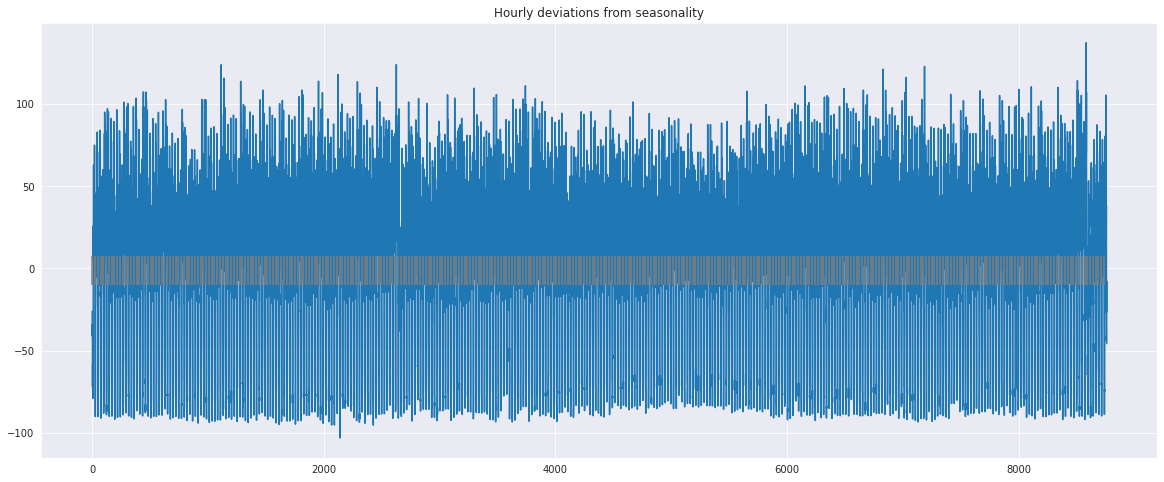

In [90]:
plt.plot(Y_true)
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -10, 7.5, color='grey')
plt.show()

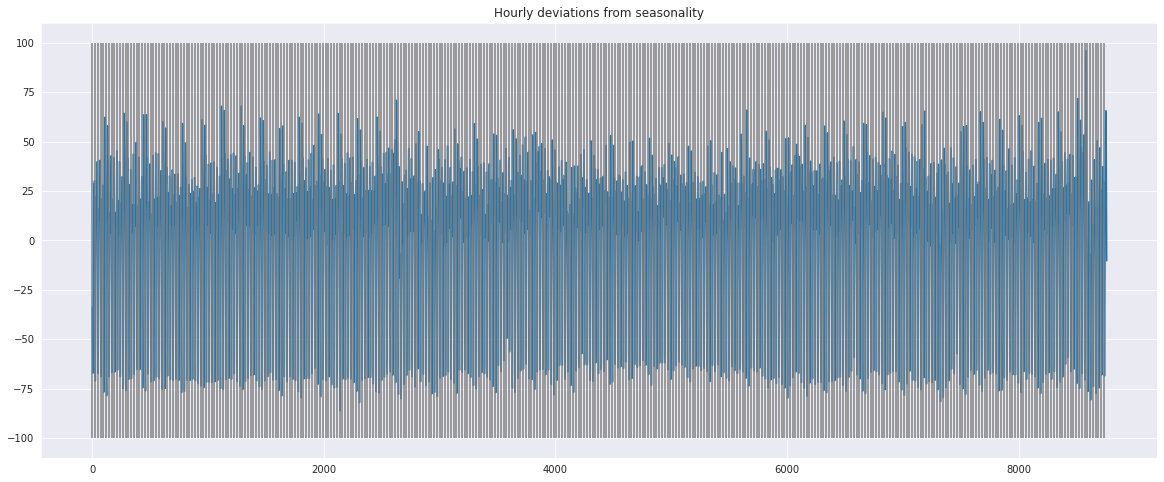

In [91]:
plt.plot(pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean())
plt.title("Hourly deviations from seasonality")
plt.vlines(np.array([24*i for i in range(Y_true.shape[0] // 24)]), -100, 100, color='grey')
plt.show()

In [92]:
print(Y_true.shape)
Y_true = pd.Series(Y_true[:, 0]).rolling(6, center=True, min_periods=2).mean().values.reshape(-1, 1)
print(Y_true.shape)

(8760, 1)
(8760, 1)


# Build model

In [93]:
n = 6
l = 3
lr = 0.03271365590433669
ITER = 714450


lr = 0.1
ITER = 70000

TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

In [94]:
hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)

In [95]:
start = time.perf_counter()
densehmm.fit_coocs(Y_true,lengths)
time_tmp = time.perf_counter() - start

         1     -194304.9614             +nan
         2     -192511.0553       +1793.9061
         3     -191481.4519       +1029.6034
         4     -190577.2083        +904.2435
         5     -189919.8553        +657.3531
         6     -189456.0830        +463.7722
         7     -188988.8217        +467.2613
         8     -188521.0081        +467.8136
         9     -188212.1359        +308.8722
        10     -187986.2057        +225.9302
        11     -187801.7651        +184.4405
        12     -187723.0426         +78.7225
        13     -187742.7395         -19.6969
        14     -187786.3492         -43.6098
        15     -187832.5846         -46.2354
        16     -187879.9493         -47.3647
        17     -187929.2499         -49.3006
        18     -187981.1765         -51.9266
        19     -188035.9526         -54.7761
        20     -188093.3194         -57.3668
        21     -188152.5870         -59.2676
        22     -188212.7822         -60.1952
        23

In [96]:
# densehmm_org_aparms = densehmm
# densehmm_100k = densehmm
# densehmm_200k = densehmm
# densehmm_700k = densehmm
# densehmm_500k = densehmm

# Results

## Embeddings movement

In [97]:
z_init = np.transpose(hmm_monitor.z[-1])
pca_z = PCA(n_components=2).fit(z_init)
z = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]

z0 = list(hmm_monitor.z0)

u_init = hmm_monitor.u[-1]
pca_u = PCA(n_components=2).fit(u_init)
u = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]

In [98]:
# Draw embeddings trajectories

def draw_embeddings(embeding_list, name="?"):
    fig = plt.figure(figsize=(5, 5))
    camera = Camera(fig)
    cmap = cm.rainbow(np.linspace(0, 1, len(embeding_list[0])))
    for z_el in embeding_list:
        if z_el.shape[1] > 1:
            plt.scatter(z_el[:, 0], z_el[:, 1], color=cmap)
        else:
            plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
        camera.snap()
    plt.title(f"Embaddings trajectory:  {name}")
    animation = camera.animate().to_html5_video()
    wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation)})
    display(HTML(animation))
    plt.close()

In [99]:
draw_embeddings(z, "z")
draw_embeddings(z0, "z0")
draw_embeddings(u, "u")

## Embedding similarities

In [100]:
# Draw graph scaled with width and alpha
representation = densehmm.get_representations()

In [101]:
u_fin, z_fin, z0_fin = representation

In [102]:
u_fin

array([[ 0.71649989,  1.18057396,  1.24367161],
       [-1.17553414, -1.40106025, -0.68452388],
       [-1.82866241,  2.05399839, -0.00477255],
       [ 0.7261496 ,  0.06853687, -0.37898983],
       [ 1.47843429, -1.47011381, -0.15902058],
       [-1.03211891,  1.90196759,  1.15924535]])

In [103]:
z_fin

array([[ 0.66520123, -1.24321427, -1.03484283,  2.21411452,  0.29780511,
        -0.75562264],
       [ 0.53409442, -0.42713542,  0.29457482, -1.01968372, -2.22458899,
         0.43304126],
       [ 1.90665861, -0.52063434, -0.01801767,  0.05644132,  0.6770349 ,
         1.34353577]])

In [104]:
z0_fin

array([[ 1.22381547],
       [-0.99308928],
       [ 0.00713517]])

In [105]:
np.matmul(u_fin, z_fin)

array([[ 3.47841176, -2.042526  , -0.41610547,  0.45279523, -1.57090542,
         1.64075099],
       [-2.83541857,  2.41626992,  0.81610953, -1.21276431,  2.30325657,
        -0.638139  ],
       [-0.12849904,  1.39856851,  2.49752039, -6.1435661 , -5.1171184 ,
         2.26483268],
       [-0.20296346, -0.73471895, -0.72443296,  1.51650176, -0.19280465,
        -1.02820218],
       [-0.10492124, -1.12728136, -1.96014046,  4.76349862,  3.60302181,
        -1.9674082 ],
       [ 2.53954864, -0.1327957 ,  1.60746572, -4.15920552, -3.75361688,
         3.16101046]])

In [106]:
z0_fin_red = z0[-1]
z_fin_red = z[-1]
u_fin_red = u[-1]

In [107]:
A_trained = np.exp(np.matmul(u_fin, z_fin)) / np.exp(np.matmul(u_fin, z_fin)).sum(axis=1).reshape(-1, 1)

In [108]:
A_largest = A_trained * (A_trained == A_trained.max(axis=1).reshape(-1, 1))

In [109]:
A_largest

array([[0.80743729, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.45999558, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.45482311, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.60595807, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.75404394, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55946464]])

In [110]:
import itertools

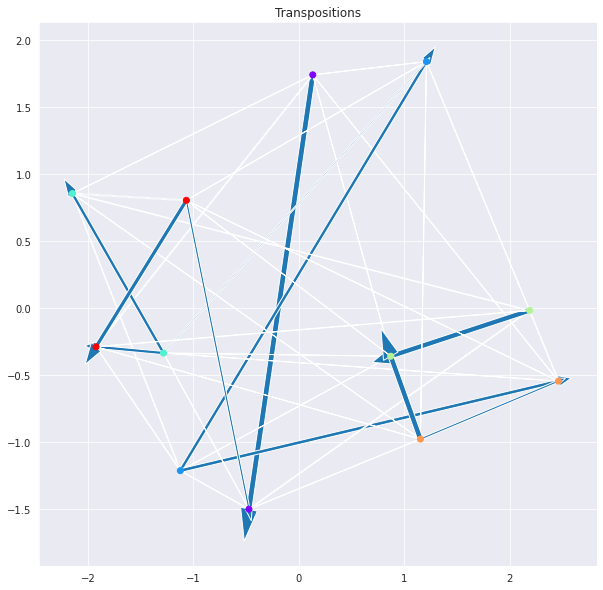

In [111]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    plt.arrow(z_fin_red[i, 0], z_fin_red[i, 1], u_fin_red[j, 0] - z_fin_red[i, 0], u_fin_red[j, 1] - z_fin_red[i, 1], width=A_trained[i, j]/15)

plt.scatter(z_fin_red[:, 0], z_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(u_fin_red[:, 0], u_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

In [112]:
z_fin_red

array([[ 0.13195349,  1.73868256],
       [-1.12310786, -1.21195252],
       [-1.28267252, -0.33530737],
       [ 2.18767914, -0.01805242],
       [ 1.15206423, -0.976552  ],
       [-1.06591648,  0.80318174]])

In [113]:
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [114]:
pca_uz = PCA(n_components=2)
uz_fin_red = pca_uz.fit_transform(uz_fin)

In [115]:
uz_fin_red

array([[-0.61843575, -2.13404818],
       [ 0.5242537 ,  2.65714888],
       [-2.41232629,  0.95036373],
       [ 1.83646929, -0.99792603],
       [ 2.94848075,  0.06293753],
       [-2.27844169, -0.53847594]])

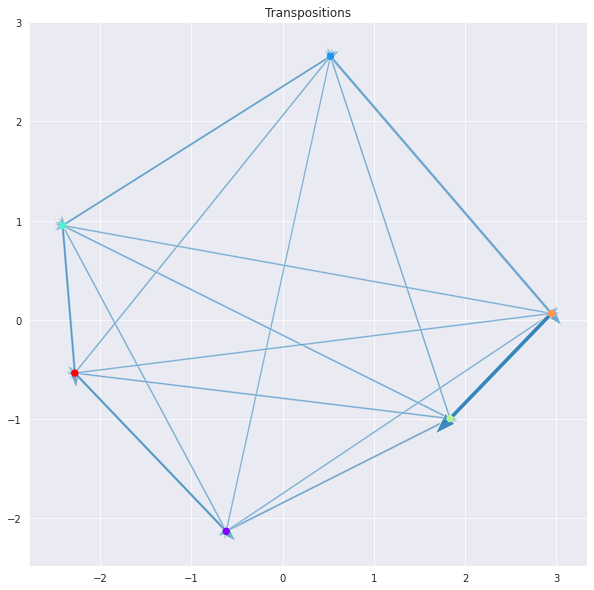

In [116]:
plt.figure(figsize=(10, 10))

for i, j in itertools.product(range(n), range(n)):
    if i == j:
        continue
    plt.arrow(uz_fin_red[i, 0], uz_fin_red[i, 1], uz_fin_red[j, 0] - uz_fin_red[i, 0], uz_fin_red[j, 1] - uz_fin_red[i, 1], width=(A_trained[i, j] / 1.5 + 0.33) * 0.06, alpha=A_trained[i, j] / 1.5 + 0.33)  #, color=cm.rainbow(A_trained[i, j] )

plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))
plt.scatter(uz_fin_red[:, 0], uz_fin_red[:, 1], color = cm.rainbow(np.linspace(0, 1, n)))

plt.title("Transpositions")
plt.show()

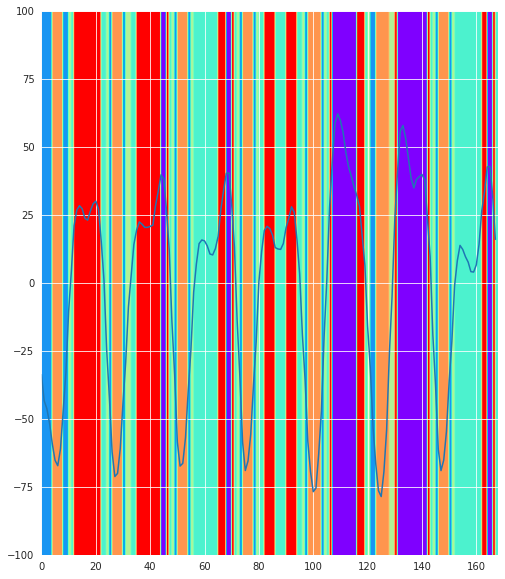

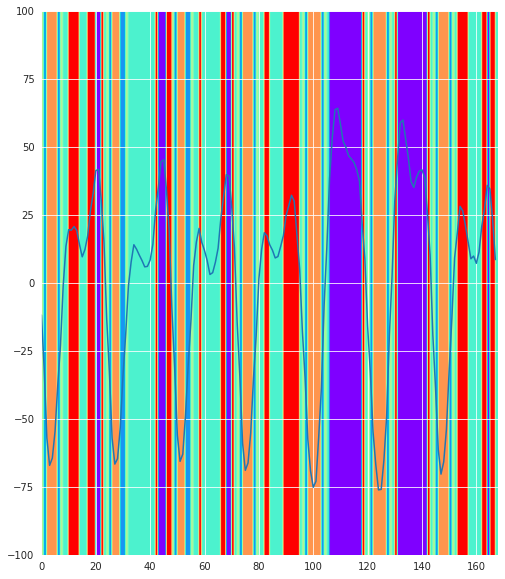

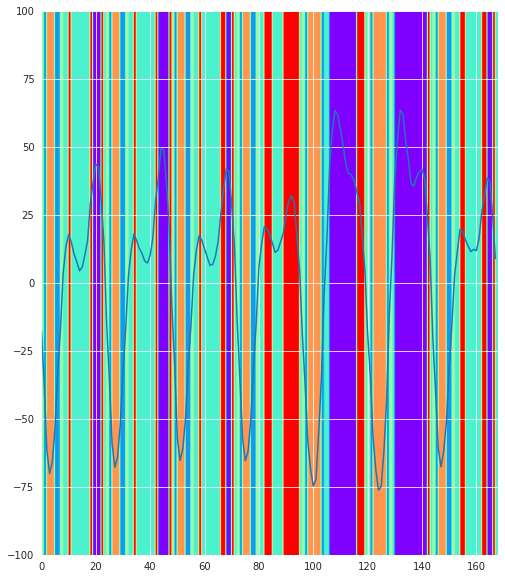

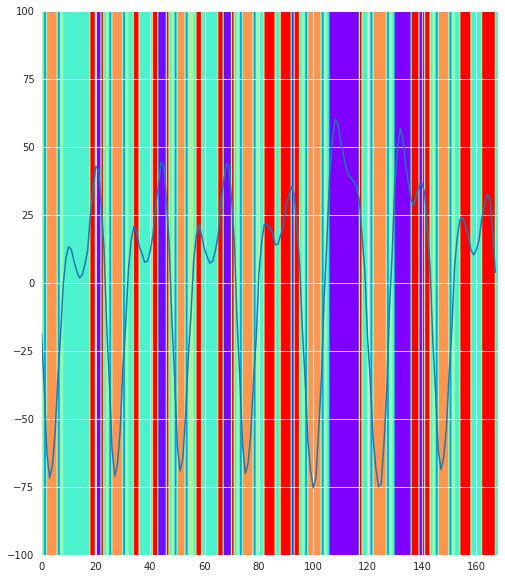

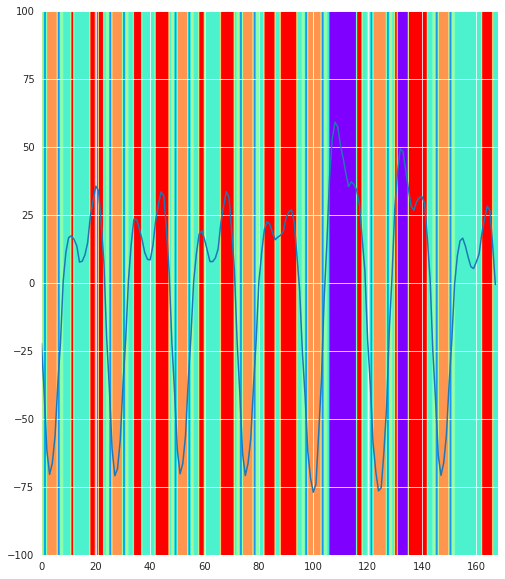

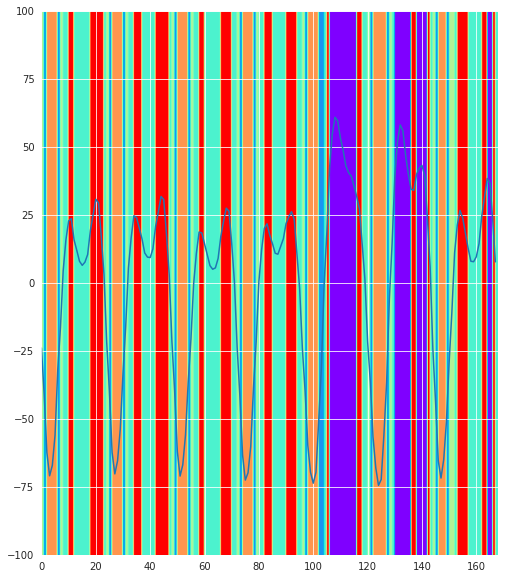

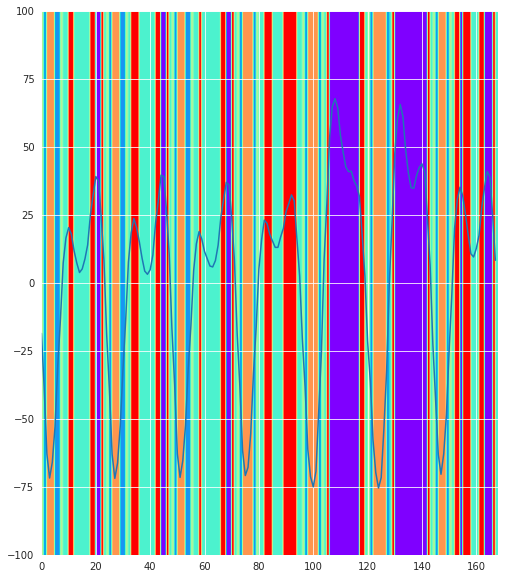

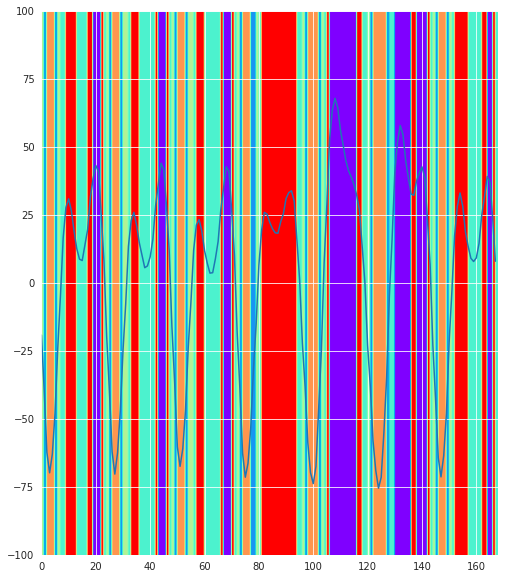

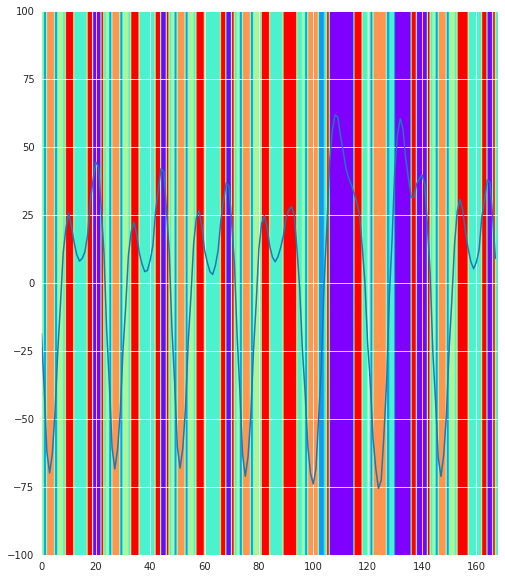

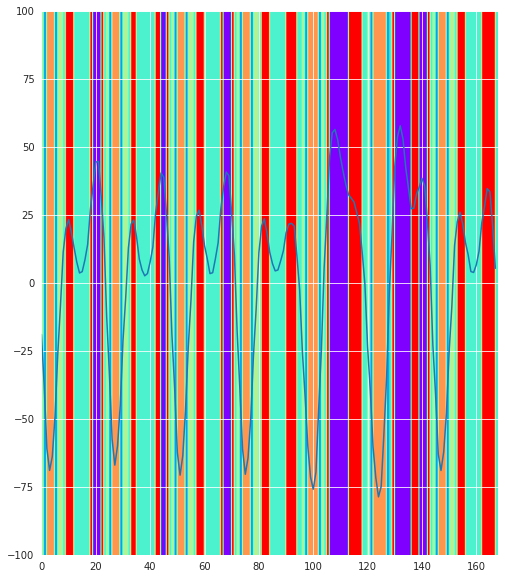

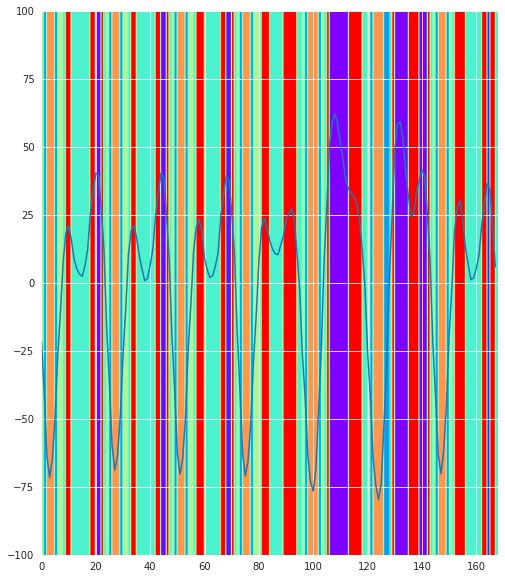

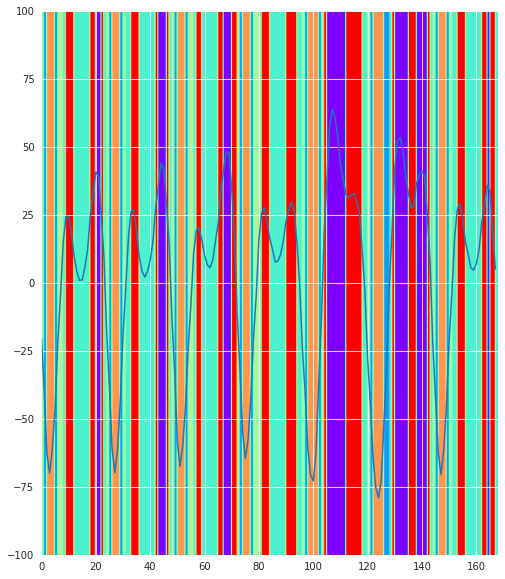

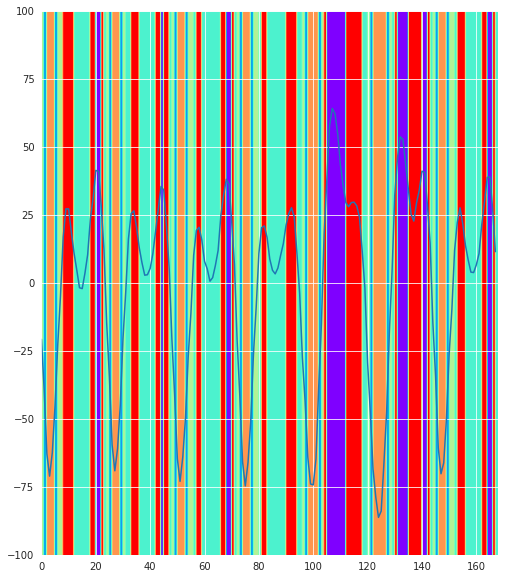

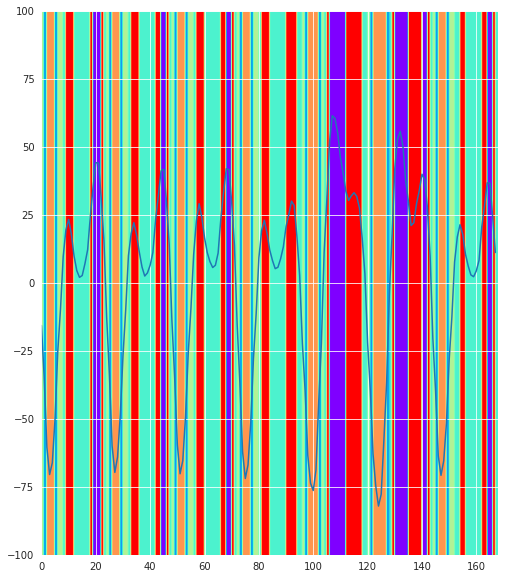

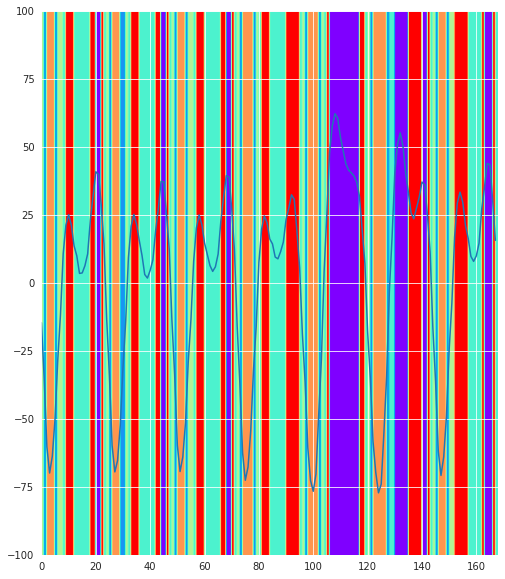

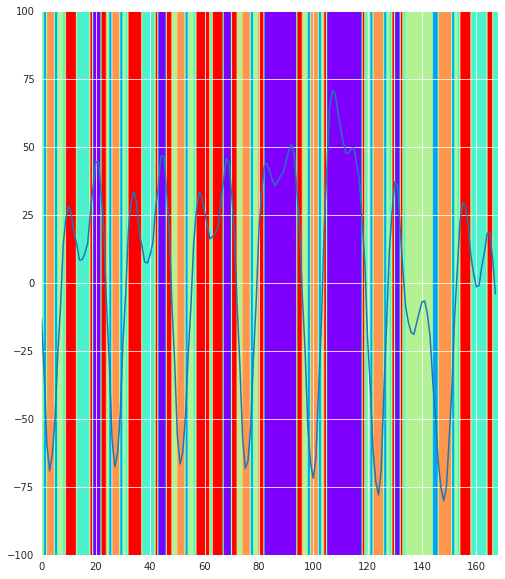

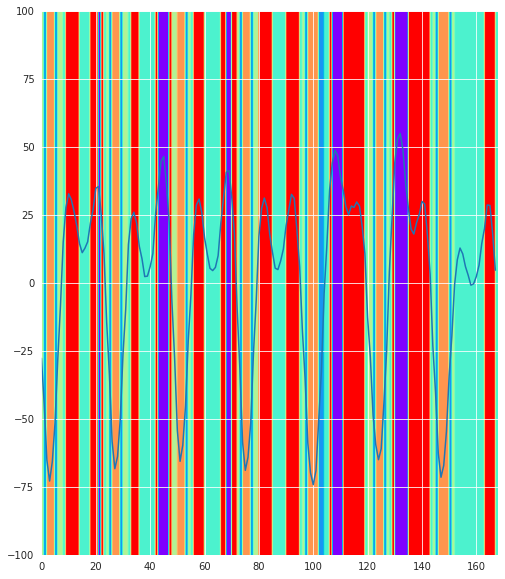

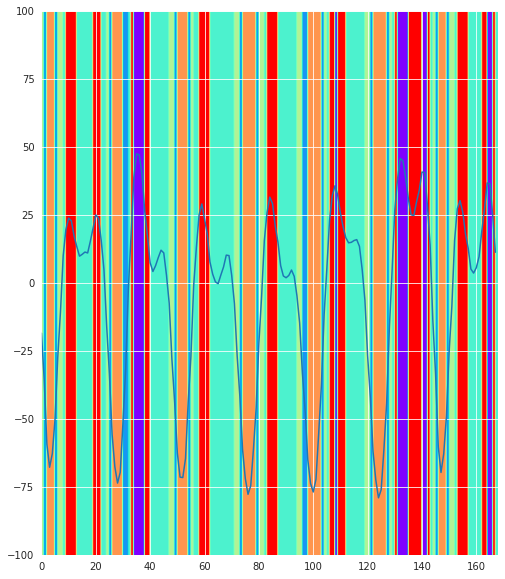

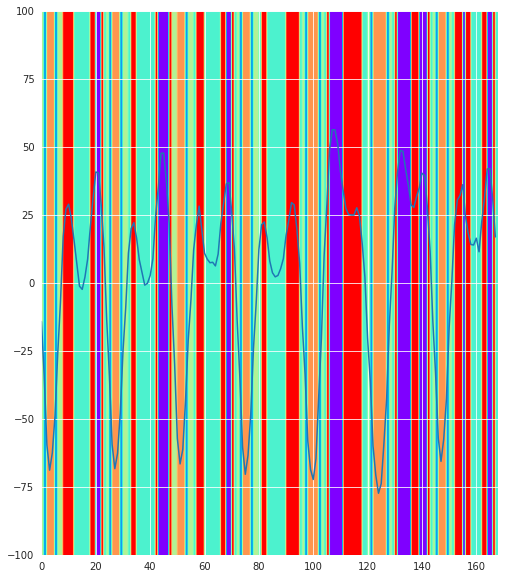

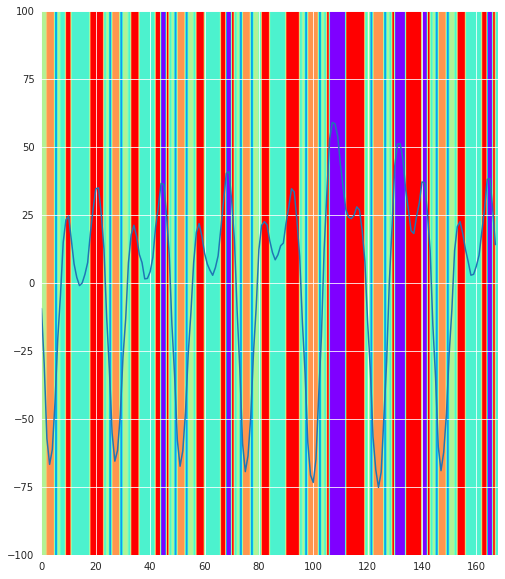

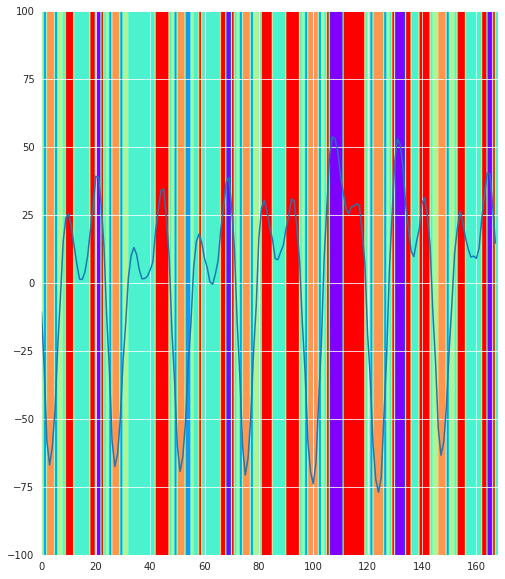

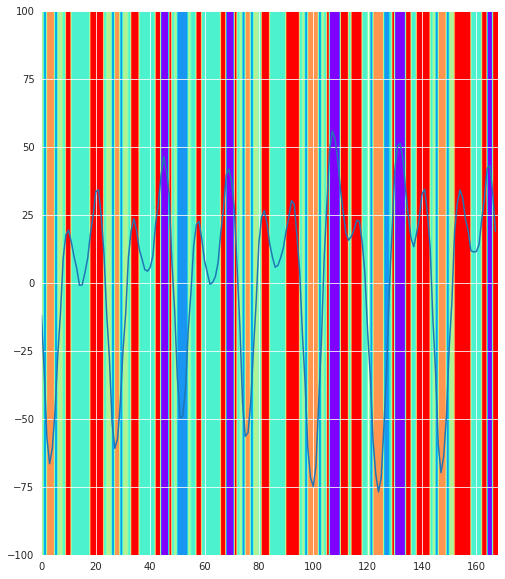

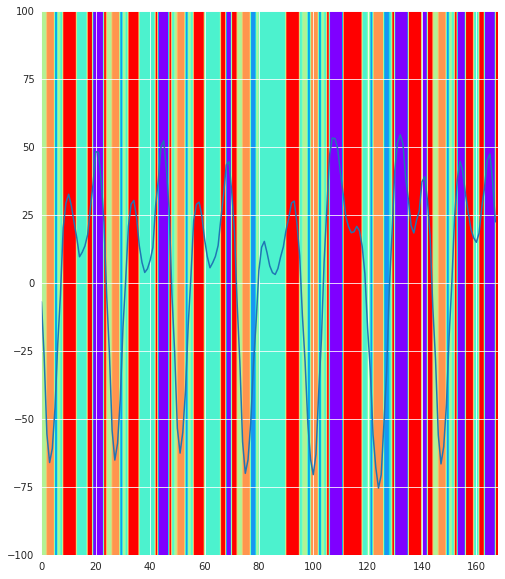

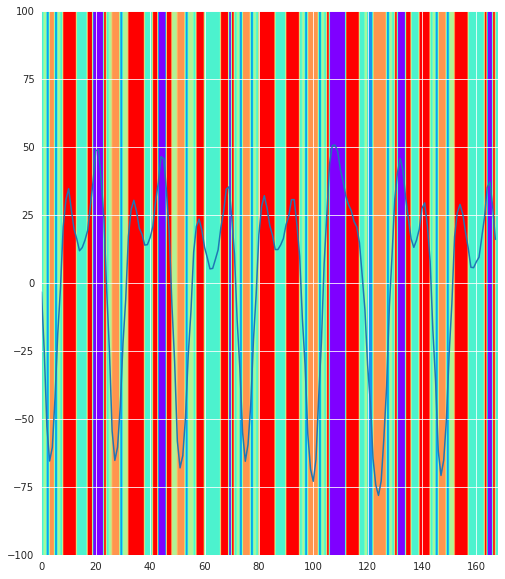

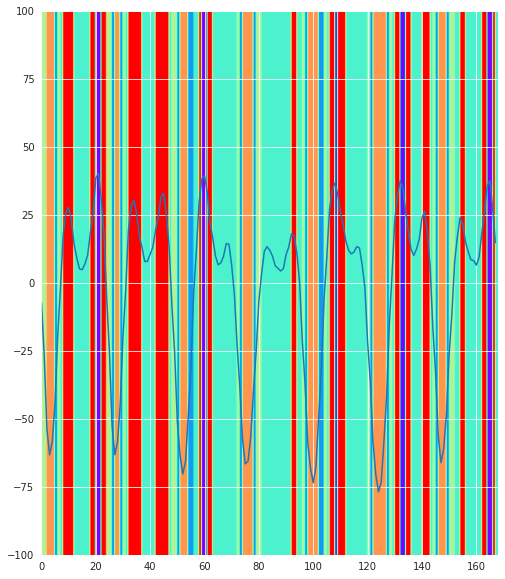

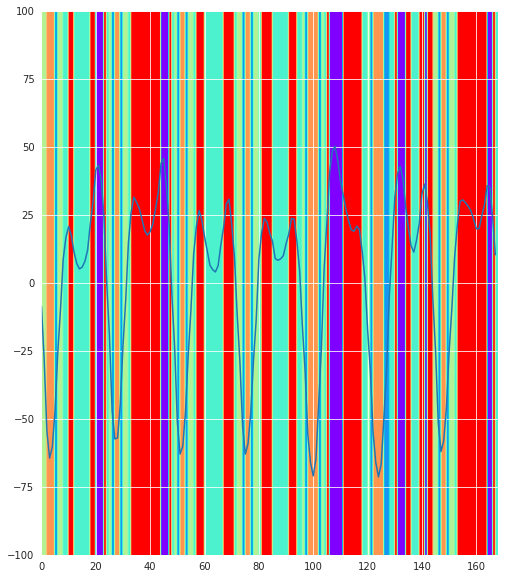

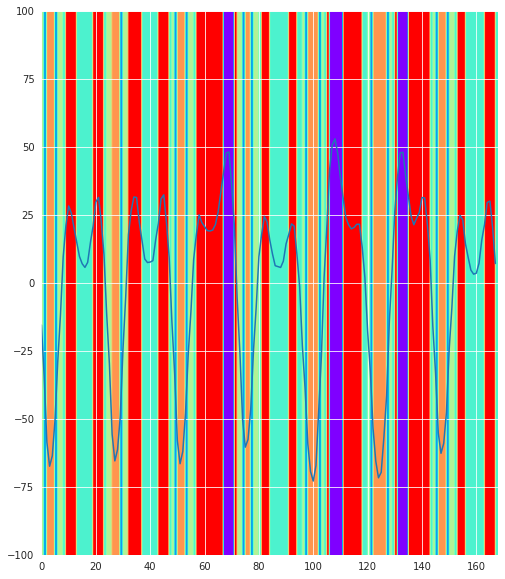

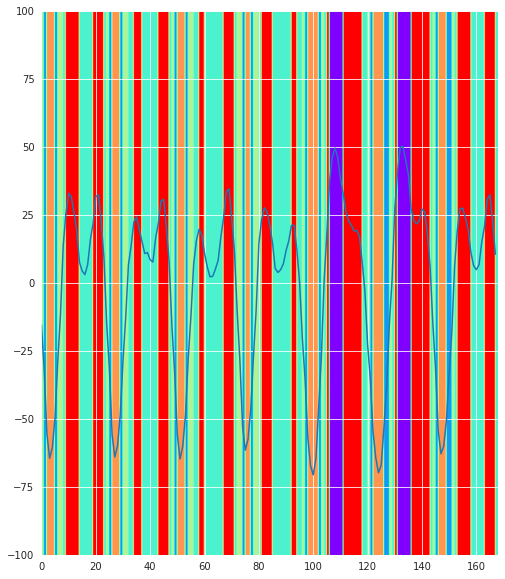

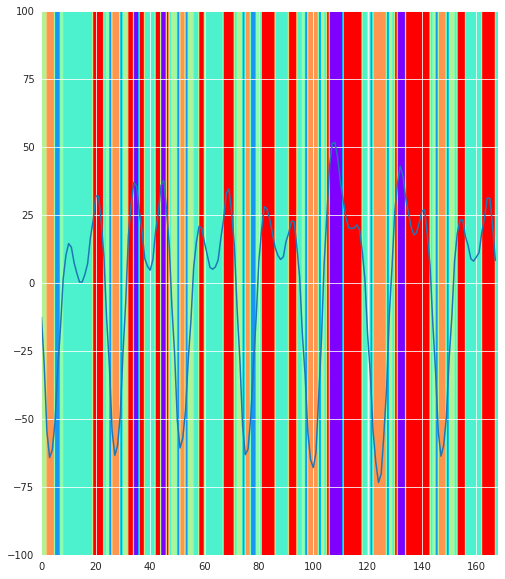

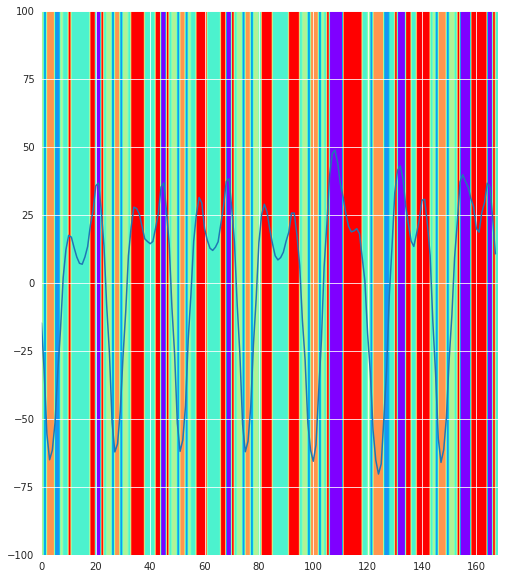

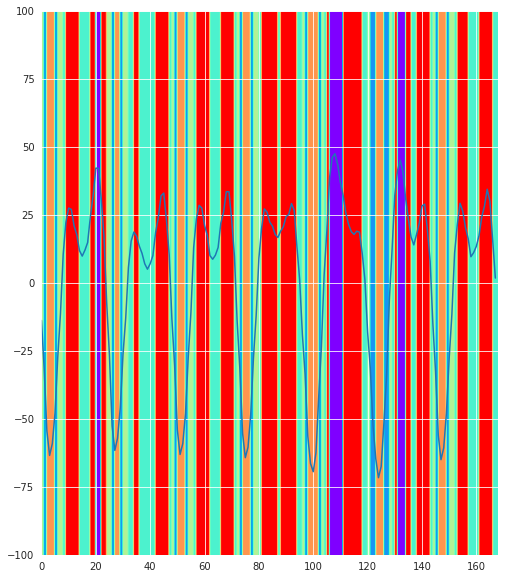

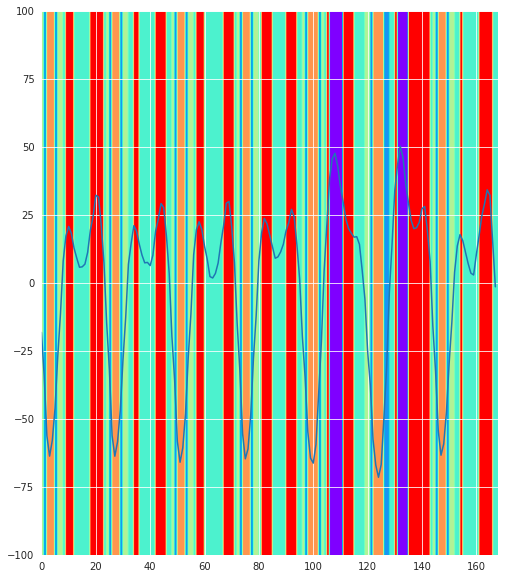

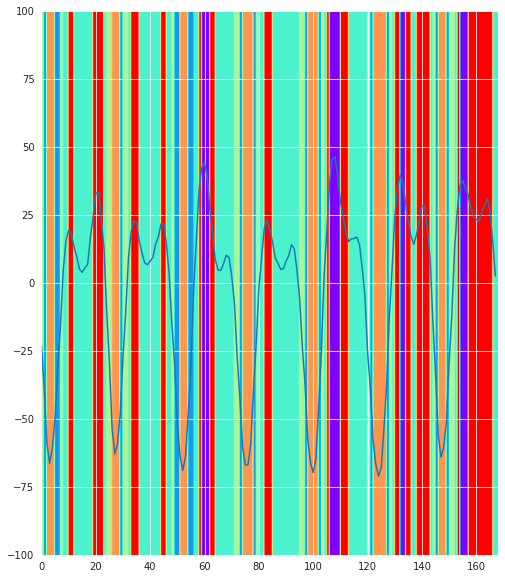

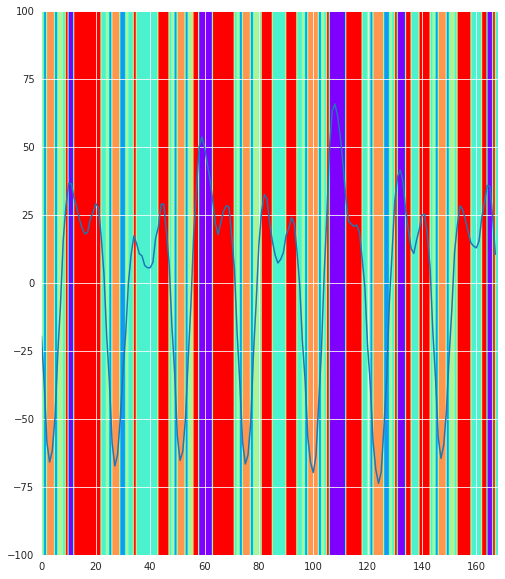

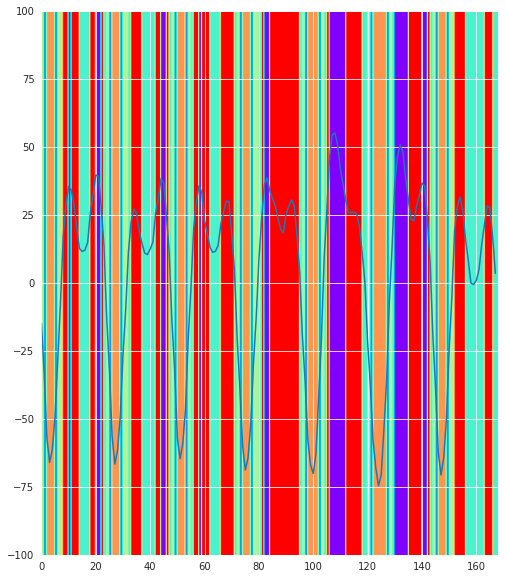

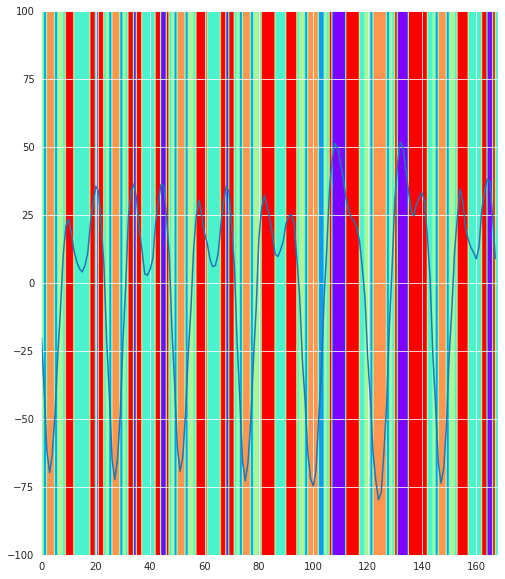

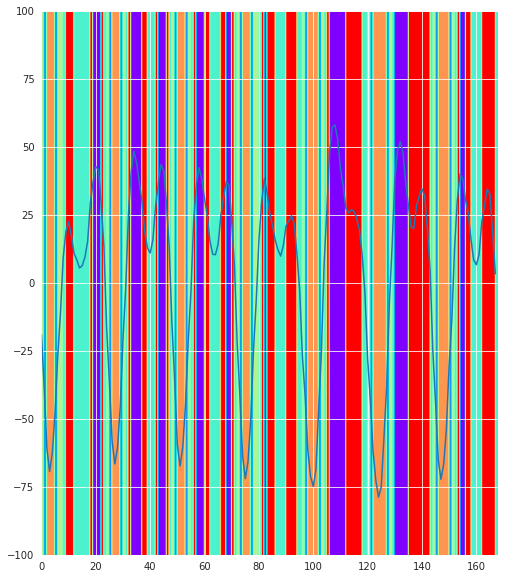

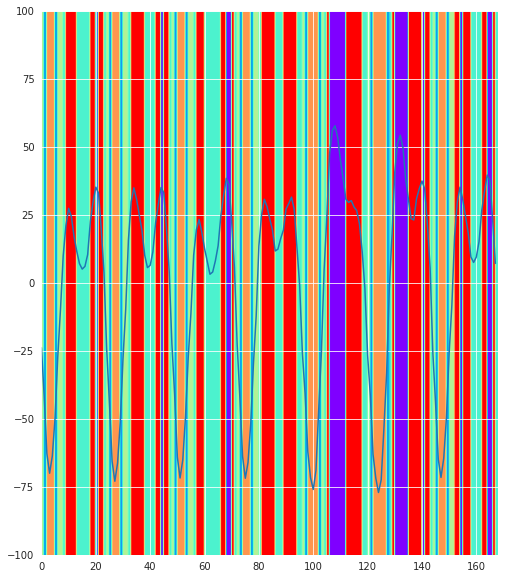

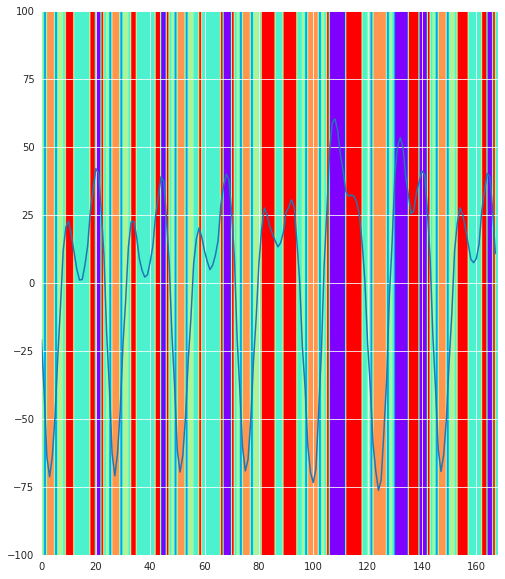

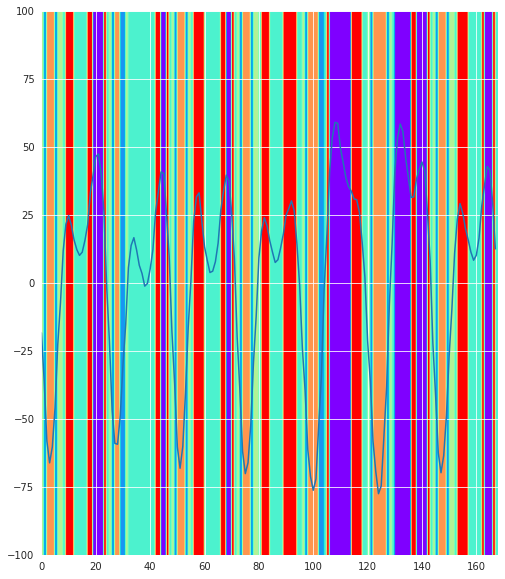

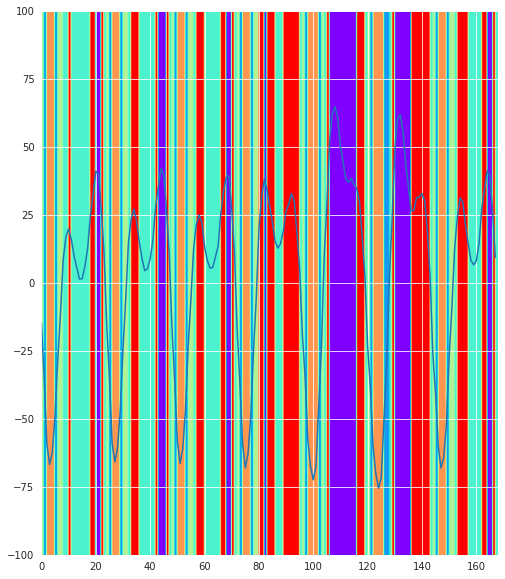

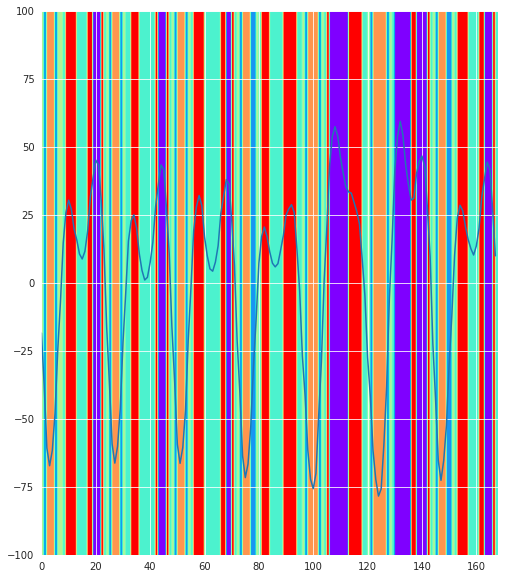

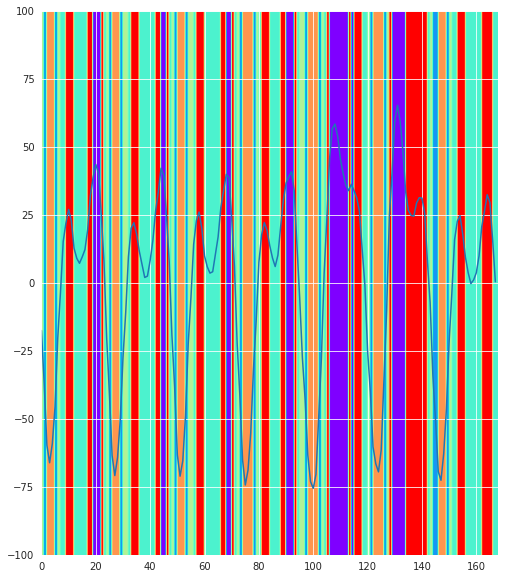

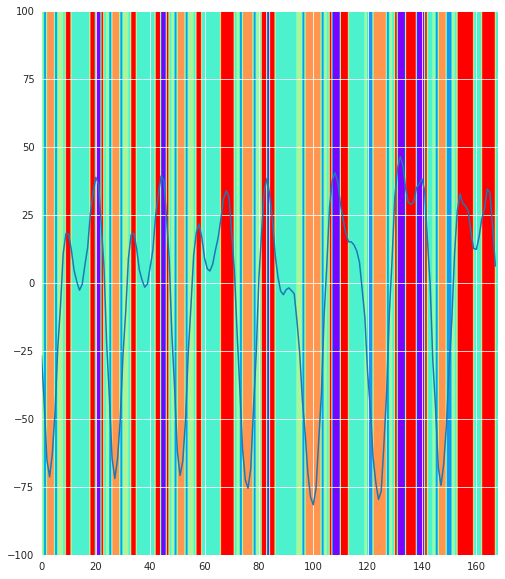

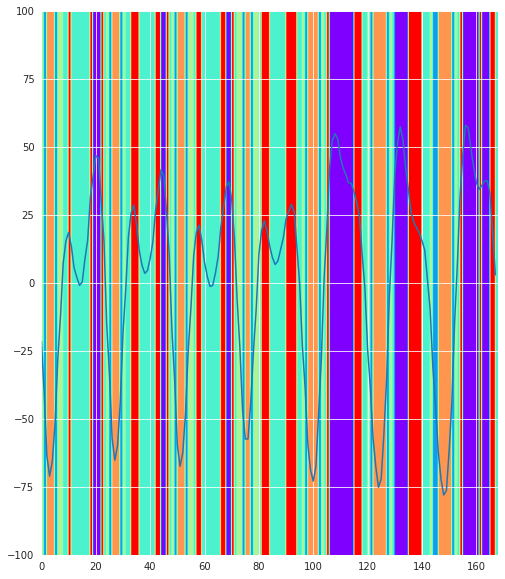

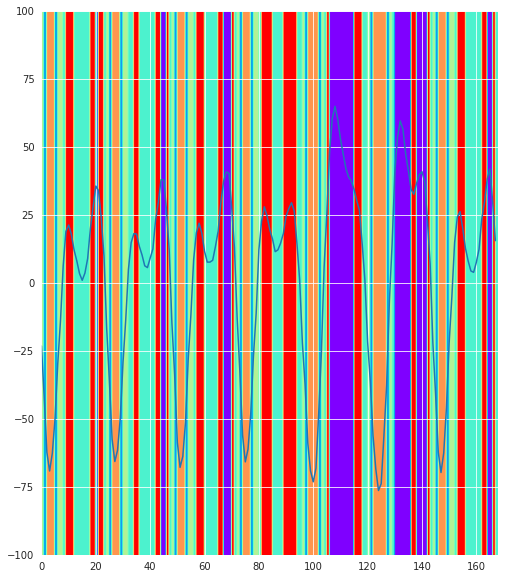

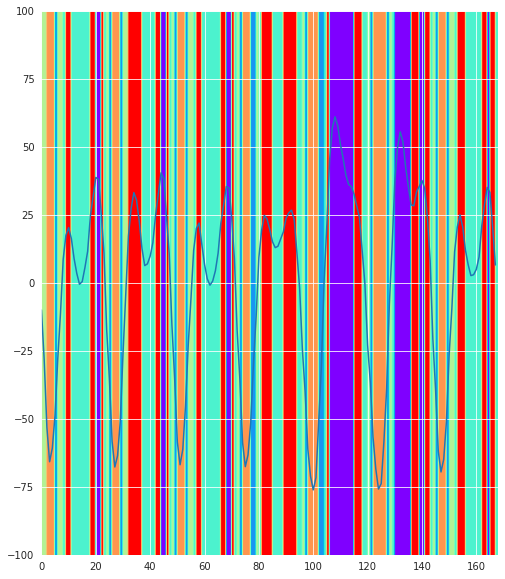

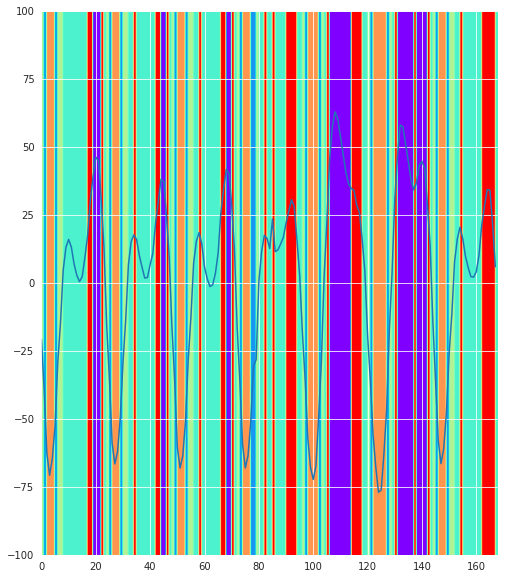

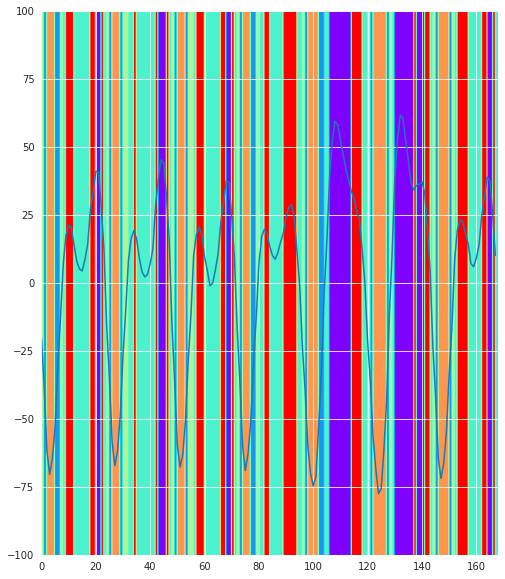

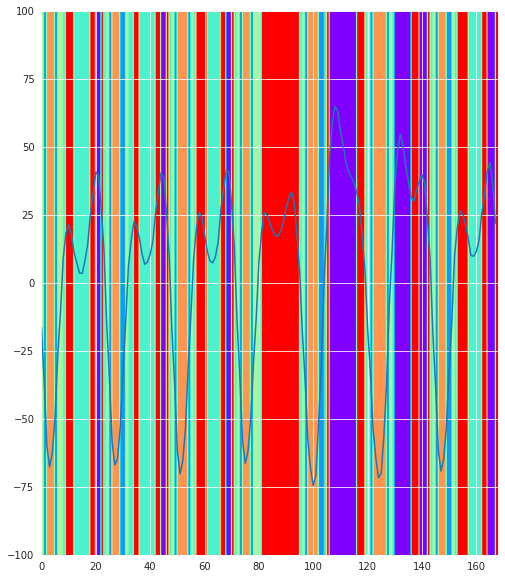

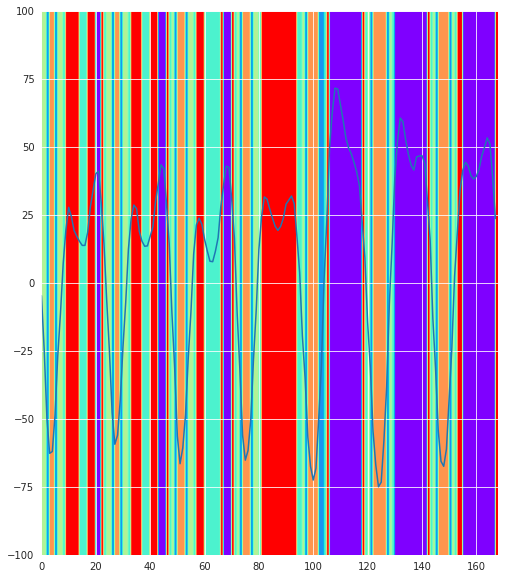

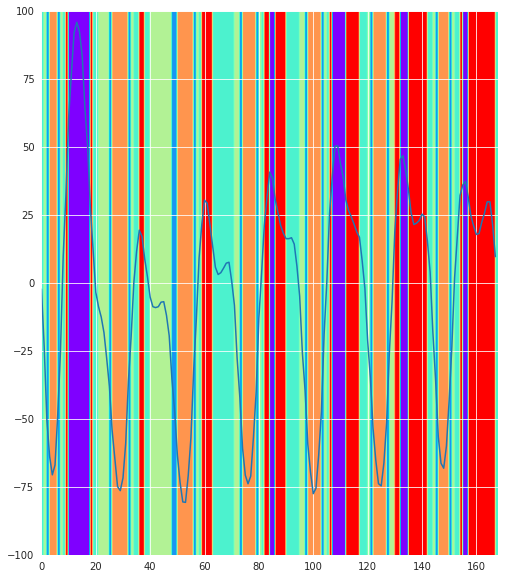

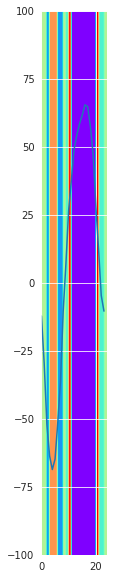

In [117]:
states = densehmm.predict(Y_true).reshape(1, -1)

interval = 7 * 24

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(10, 10))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -100, 100), cmap=cm.rainbow)
    plt.show()

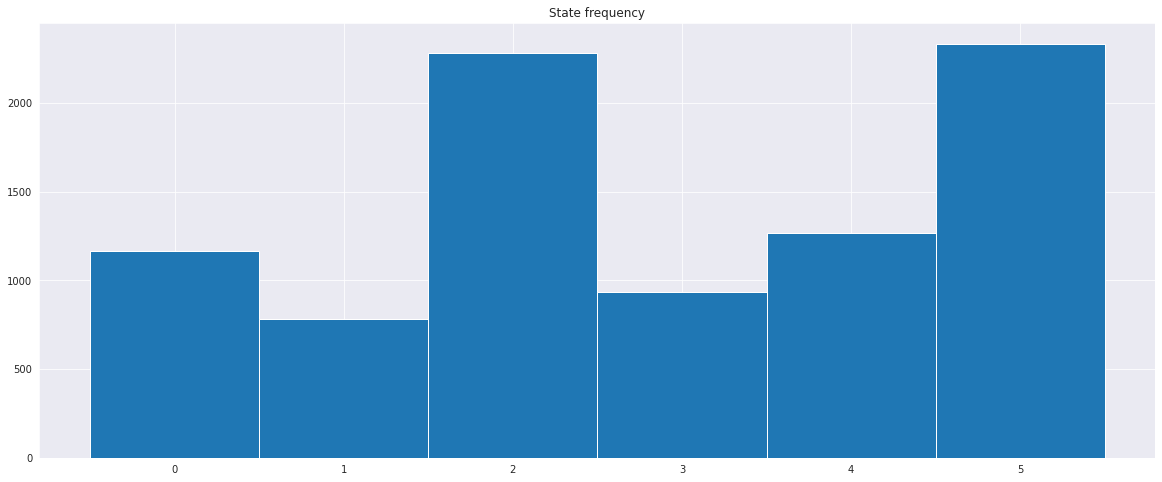

In [118]:
plt.hist(densehmm.predict(Y_true).reshape(-1), [i - 0.5 for i in range(n+1)])
plt.title("State frequency")
plt.show()

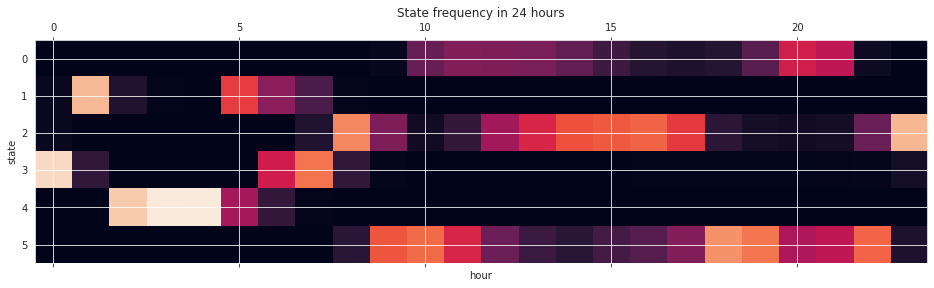

In [119]:
plt.matshow(pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24 }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

In [1]:
weekly = pd.DataFrame({"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 7) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
l = weekly.shape[1] // 7
days = ['wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'poniedziałek']
for i in range(7):
    plt.matshow(weekly[:, (l*i) : (l*(i+1))])
    plt.ylabel("state")
    plt.xlabel("hour")
    plt.title(f"State frequency in 24 hours: {days[i]}")
    plt.show()

NameError: name 'pd' is not defined